#### *Using a VGG16 Model to train Faces, againsts cars*


In [6]:
from sklearn.model_selection import train_test_split

import os
import glob
import random
import pandas as pd
import numpy as np

import tensorflow_addons as tfa

import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm

from PIL import Image
import cv2 as cv

from keras.utils import to_categorical

import seaborn as sns
import matplotlib.image as img
import matplotlib.pyplot as plt


##### *Preparing the data*

I am using the Labeled Faces in the Wild dataset from University of Massachusetts as my source for face data. I decided to make a dataframe with the file location rather then loading the entire image data to reduce having to work with the unwieldy data on my computer.

In [7]:
DATA_PATH = 'lfw_funneled/'
img_list = []
img_dir = []
img_label = []


for files in os.listdir(DATA_PATH):
    if files[len(files)-4:len(files)] != '.txt':
        for img in os.listdir(DATA_PATH + files):
            img_list.append(img)
            img_dir.append(DATA_PATH + files+'/'+img)

for i in range(len(img_list)):
    img_label.append('face')
        

I arbitrarily chose The Car Connection Picture Dataset to train the faces against. Any non face dataset would work. Again, I opted to only make dataframes with string info on the file locations.

In [8]:
nf_img_list = []
nf_img_dir = []
nf_img_label = []

for files in os.listdir('NotFaces'):
    nf_img_list.append(files)
    nf_img_dir.append('NotFaces/'+files)

for i in range(len(nf_img_list)):
    nf_img_label.append('not face')



I wanted to combine both dataframes so have a single dataframe so I can use the train_test_split utility.

In [9]:
for i in range(len(nf_img_list)):
    img_dir.append(nf_img_dir[i])
    img_list.append(nf_img_list[i])
    img_label.append(nf_img_label[i])

    

In [10]:
full_dataDF = pd.DataFrame({'image directory': img_dir, 'image': img_list, 'label': img_label})

In [11]:
full_dataDF

,image directory,image,label
0,lfw_funneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg,Aaron_Eckhart_0001.jpg,face
1,lfw_funneled/Aaron_Guiel/Aaron_Guiel_0001.jpg,Aaron_Guiel_0001.jpg,face
2,lfw_funneled/Aaron_Patterson/Aaron_Patterson_0...,Aaron_Patterson_0001.jpg,face
3,lfw_funneled/Aaron_Peirsol/Aaron_Peirsol_0001.jpg,Aaron_Peirsol_0001.jpg,face
4,lfw_funneled/Aaron_Peirsol/Aaron_Peirsol_0002.jpg,Aaron_Peirsol_0002.jpg,face
...,...,...,...
23142,NotFaces/BMW_Z4_2019_49_18_250_20_4_73_51_170_...,BMW_Z4_2019_49_18_250_20_4_73_51_170_25_RWD_2_...,not face
23143,NotFaces/BMW_Z4_2019_49_18_250_20_4_73_51_170_...,BMW_Z4_2019_49_18_250_20_4_73_51_170_25_RWD_2_...,not face
23144,NotFaces/BMW_Z4_2019_49_18_250_20_4_73_51_170_...,BMW_Z4_2019_49_18_250_20_4_73_51_170_25_RWD_2_...,not face
23145,NotFaces/BMW_Z4_2019_49_18_250_20_4_73_51_170_...,BMW_Z4_2019_49_18_250_20_4_73_51_170_25_RWD_2_...,not face


With all the data in one dataframe, I decided to resize to 160x160 samples to input into the VGG16 model. 160x160 kept enough info for me to see a picture nicely and for the model to have enough pixels to work with. Although 160x160 is more then enough, I chose this size mainly for myself to see a clearer image without making the training too long.

In [12]:
img_data_array = []
all_img_label = []
for i in range(len(full_dataDF)):
    t = full_dataDF['image directory'][i]
    temp_img = Image.open(t)
    img_data_array.append(np.asarray(temp_img.resize((160,160))))
    all_img_label.append(full_dataDF['label'][i])

In [13]:

inp_shape = (160,160,3)
X_train, X_test, y_train, y_test = train_test_split(img_data_array, all_img_label, test_size=0.33, random_state=42)
X_train = np.asarray(X_train)
y_train = to_categorical(np.asarray(pd.Series(y_train).factorize()[0]))
y_test = to_categorical(np.asarray(pd.Series(y_test).factorize()[0]))

I wanted a model that was image size specific on creation and very simple. I'm adding my own dense layers, and only want to classify 2 patterns, face and not face.

In [14]:
vgg_model = Sequential()

vggmodel = tf.keras.applications.VGG16(
        include_top=False,
        input_shape=inp_shape,
        pooling='avg',
        classes=2,
        weights='imagenet'
        )

for layer in vggmodel.layers:
        layer.trainable=False

vgg_model.add(vggmodel)
vgg_model.add(Flatten())
vgg_model.add(Dense(512, activation='relu'))
vgg_model.add(Dense(2, activation='softmax'))

In [15]:
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
history = vgg_model.fit(X_train,y_train, epochs=4)

Epoch 1/4
485/485 [==============================] - 445s 916ms/step - loss: 0.0197 - accuracy: 0.9977
Epoch 2/4
485/485 [==============================] - 449s 926ms/step - loss: 0.0075 - accuracy: 0.9994
Epoch 3/4
485/485 [==============================] - 452s 931ms/step - loss: 0.0010 - accuracy: 0.9999
Epoch 4/4
485/485 [==============================] - 452s 933ms/step - loss: 1.0392e-07 - accuracy: 1.0000


In [45]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 14,978,370
Trainable params: 263,682
Non-trainable params: 14,714,688
_________________________________________________________________


In [26]:
vgg_model.save_weights("FaceVcars_model.h5")

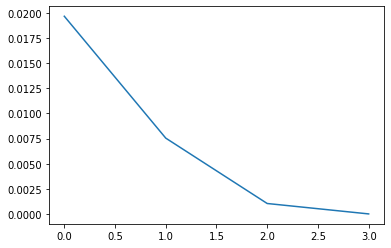

In [17]:
losss = history.history['loss']
plt.plot(losss)

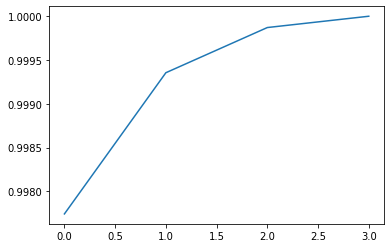

In [18]:
accu = history.history['accuracy']
plt.plot(accu)


In [19]:
def read_image(fn):
    image = Image.open(fn)
    return np.asarray(image.resize((160,160)))

In [20]:
CATAGORIES=['not face', 'face']

In [38]:
def test_predict_new_image(test_image):
    result = vgg_model.predict(np.asarray([read_image(test_image)]))

    itemindex = np.where(result==np.max(result))
    prediction = itemindex[1][0]
    print("probability: "+str(np.max(result)*100) + "%\nPredicted class : ", CATAGORIES[prediction])

    image = read_image(test_image)
    plt.imshow(image)
    plt.title(prediction)

def test_predict_X_test(test_image):
    result = vgg_model.predict(np.asarray([test_image]))

    itemindex = np.where(result==np.max(result))
    prediction = itemindex[1][0]
    print("probability: "+str(np.max(result)*100) + "%\nPredicted class : ", CATAGORIES[prediction])

    
    plt.imshow(Image.fromarray(test_image))
    plt.title(prediction)

1/1 [==============================] - 0s 60ms/step
probability: 100.0%
Predicted class :  not face


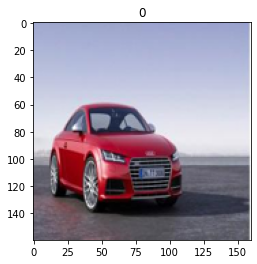

In [26]:

test_predict_X_test(X_test[1])

1/1 [==============================] - 0s 46ms/step
probability: 99.96482133865356%
Predicted class :  face


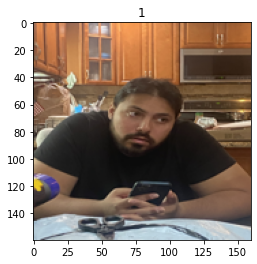

In [44]:
test_predict_new_image('IMG_3645.jpeg')

I wrote two functions, one for external images, my friend who involentarily volenteered, and one for images from the x_test set. My concerns here are that my model might be overtrained, yet with some testing it still performs well with external images.